## Feature check

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import sys
from safety_perception_dataset import SafetyPerceptionCLIPDataset
import numpy as np
import pandas as pd
from tqdm import tqdm
import neptune
sys.path.append("/code/LLM-crime/safety_perception_model/single_model")
from my_models import TransformerRegressionModel, FeatureViTClassifier
sys.path.append("/code/LLM-crime")
from custom_clip_train import CLIPModel, CLIPDataset, build_loaders, make_prediction
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

def get_img_feature(paras):
    CLIP_model_path = os.path.join(paras['save_model_path'], paras['save_model_name'])
    save_paths = paras['variables_save_paths']
    if not os.path.exists(save_paths):
        os.makedirs(save_paths)
    text_tokenizer = "distilbert-base-uncased"
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {paras['device']}")

    img_encoder_paras = torch.load(CLIP_model_path)
    img_encoder = CLIPModel(paras)
    img_encoder.load_state_dict(img_encoder_paras)
    baseline_data = pd.read_csv(paras['dataset_path'])
    # print("baseline_data: ", len(baseline_data))
    tokenizer = DistilBertTokenizer.from_pretrained(text_tokenizer)

    data_loader = build_loaders(baseline_data, tokenizer, mode="valid", cfg_paras=paras)

    img_encoder.to(paras['device'])
    img_feature, text_feature = make_prediction(img_encoder, data_loader, cfg_paras=paras) # (datasize, 256)
    img_feature = np.array(img_feature)
    text_feature = np.array(text_feature)

    # Save img_feature to a file
    np.save(os.path.join(save_paths, 'img_feature.npy'), img_feature)
    np.save(os.path.join(save_paths, 'text_feature.npy'), text_feature)
    return img_feature, text_feature

paras = {
    'debug':False,
    # 'dataset_path':"/data2/cehou/LLM_safety/img_text_data/dataset_baseline_baseline_baseline_baseline_1401.pkl",
    'dataset_path':'/data2/cehou/LLM_safety/img_text_data/baseline/tidyed/dataset_baseline_baseline_baseline_baseline_9030_withlabel.csv',
    'save_model_path':"/data2/cehou/LLM_safety/LLM_models/clip_model/test",
    'save_model_name':"model_baseline_test.pt",
    'device':torch.device("cuda:3" if torch.cuda.is_available() else "cpu"),
    'batch_size':60,
    'num_workers':4,
    'head_lr':1e-3,
    'image_encoder_lr':1e-4,
    'text_encoder_lr':1e-5,
    'weight_decay':1e-3,
    'img_type':'PlacePulse',
    'patience':1,
    'factor':0.8,
    'epochs':400,
    'image_embedding':768,
    'text_embedding':768,
    'max_length':512,
    'size':(112,112),
    
    # models for image and text
    'model_name':'resnet50',
    'text_encoder_model':"distilbert-base-uncased",
    'text_tokenizer': "distilbert-base-uncased",
    'pretrained':True,
    'trainable':True,
    
    # deep learning model parameters
    'temperature':0.07,
    'projection_dim':256,
    'dropout':0.1,
    'early_stopping_threshold':5,
    
    # safety perception
    # 'CLIP_model_path': "/data2/cehou/LLM_safety/LLM_models/clip_model/test/model_baseline_best.pt",
    'variables_save_paths': f"/data2/cehou/LLM_safety/middle_variables/test",
    'safety_model_save_path' : f"/data2/cehou/LLM_safety/LLM_models/safety_perception_model/",
    'placepulse_datapath': "/data2/cehou/LLM_safety/PlacePulse2.0/image_perception_score.csv",
    'eval_path': "/data2/cehou/LLM_safety/eval/test/",
    'train_type': 'classification',
    'safety_epochs': 200,
    'CNN_lr': 1e-2,
    
    }

img_feature,text_feature = get_img_feature(paras)
print(img_feature.shape)
data = pd.read_csv(paras['placepulse_datapath'])
SVI_namelist = pd.read_csv(paras['dataset_path'])
namelist = pd.DataFrame([SVI_namelist.loc[i,'Image_ID'] for i in range(len(SVI_namelist))],columns=['Image_ID'])
data = namelist.merge(data[data['Category'] == 'safety'], on='Image_ID')
data_nonezero = data[data['label'] != 0]
data_nonezero_idx = data[data['label'] != 0].index
img_feature_nonezero = img_feature[data_nonezero_idx,:]
data_nonezero = data_nonezero.reset_index(drop=True)

train_len = int(0.7*len(img_feature_nonezero))
train_dataset = SafetyPerceptionCLIPDataset(data[:train_len], img_feature[:train_len], paras)
valid_dataset = SafetyPerceptionCLIPDataset(data[train_len:], img_feature[train_len:], paras)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:3


100%|██████████| 151/151 [00:22<00:00,  6.62it/s]


(9030, 256)


In [5]:
low_idx, high_idx = data_nonezero.sort_values(by='Score').index[0], data_nonezero.sort_values(by='Score').index[-1]

In [10]:
data_nonezero.iloc[low_idx]['Image_ID']

'50f5e56bfdc9f065f00068c5'

<Axes: >

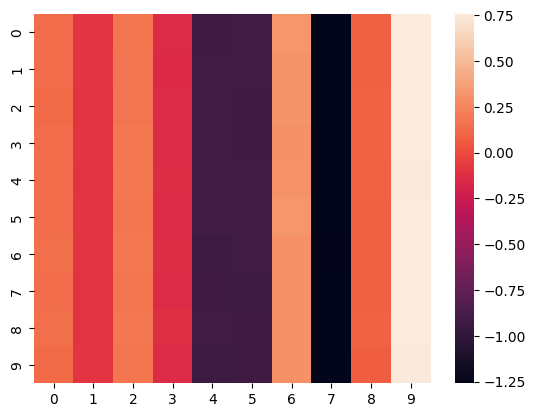

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(text_feature[:10,:10])

In [36]:
from sklearn.decomposition import PCA

# 对img_feature进行PCA
pca_img = PCA(n_components=2)
img_feature_pca = pca_img.fit_transform(img_feature)

# 对text_feature进行PCA
pca_text = PCA(n_components=2)
text_feature_pca = pca_text.fit_transform(text_feature)

print("PCA on img_feature:", img_feature_pca.shape)
print("PCA on text_feature:", text_feature_pca.shape)

PCA on img_feature: (9030, 2)
PCA on text_feature: (9030, 2)


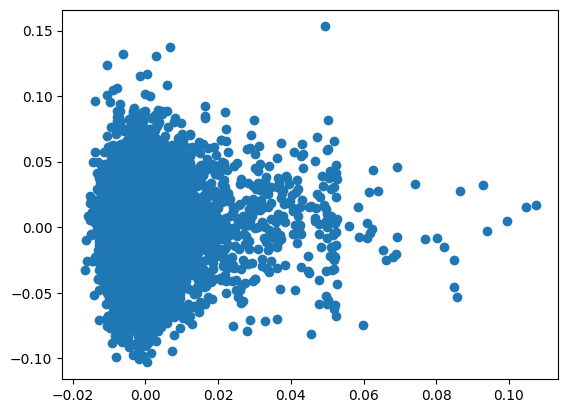

In [41]:
plt.scatter(img_feature_pca[:,1], text_feature_pca[:,1])

<Axes: >

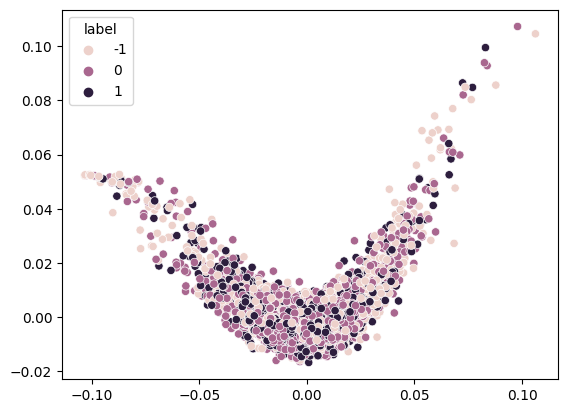

In [47]:
sns.scatterplot(x=img_feature_pca[:,0], y=img_feature_pca[:,1], hue=data['label'])

<Axes: >

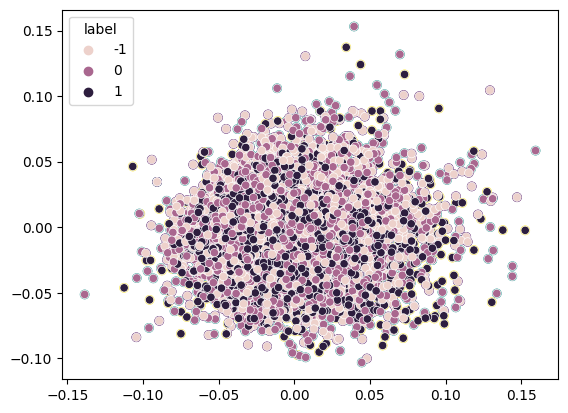

In [46]:
# plt.scatter(text_feature_pca[:,0], text_feature_pca[:,1], c=data['label'])
sns.scatterplot(x=text_feature_pca[:,0], y=text_feature_pca[:,1], hue=data['label'])